In [ ]:
!pip install node2vec

# PHẦN 1 - CHUẨN BỊ DỮ LIỆU TRAIN DATA VÀ TEST DATA

In [1]:
# Phần 1: Chuẩn bị dữ liệu
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import islice
import pandas as pd
import random
import pickle

is_checkpoint_loaded = True

print("Bắt đầu chạy code Chuẩn bị dữ liệu")
try:
  project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"

  # Đường dẫn file lưu dữ liệu huấn luyện
  train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"

  # Load đồ thị từ file graphml
  G = nx.read_graphml(f"{project_path}processed_graph.graphml")

  import os
  # Kiểm tra nếu checkpoint tồn tại
  if os.path.exists(train_test_data_checkpoint_path) and is_checkpoint_loaded:
    # Tải lại checkpoint
    with open(train_test_data_checkpoint_path, 'rb') as f:
        data = pickle.load(f)
    train_data = data["train_data"]
    train_labels = data["train_labels"]
    test_data = data["test_data"]
    test_labels = data["test_labels"]
    print("Checkpoint loaded successfully.")
  else:
    # Tách cạnh thành tập huấn luyện và kiểm tra
    print ("Tiến hành tách cạnh thành tập huấn luyện và kiểm tra....")

    # Lấy danh sách tất cả các cạnh có kết nối
    positive_edges = list(G.edges())

    # Tách positive_train và positive_test theo tỷ lệ 80 - 20
    print ("Tạo tập dữ liệu huấn luyện và kiểm tra của bộ positive edges")
    positive_train, positive_test = train_test_split(positive_edges, test_size=0.2, random_state=42)
    print(f"Số positive edges (train/test): {len(positive_train)}/{len(positive_test)}")


    # 3. Tạo negative edges (các cạnh không liên kết)

    # Số lượng negative-edges cần lấy mẫu
    num_samples = len(positive_edges) * 30  # Lấy số lượng dựa vào positive_edges
    #num_samples = len(list(nx.non_edges(G))) * 0.5 #Lấy số lượng theo tỷ lệ số non_edges
    print("Tạo tập dữ liệu huấn luyện và kiểm tra của bộ negative edges")
    print(f"Số negative edges cần lấy mẫu: {int(num_samples)}")

    negative_edges = list(islice(nx.non_edges(G), int(num_samples))) #Lấy theo tỷ lệ % của Non_Edges
    #negative_edges = list(nx.non_edges(G)) # Lấy full Non_Edges

    # Tách negative_train và negative_test theo tỷ lệ 80 - 20
    negative_train, negative_test = train_test_split(negative_edges, test_size=0.2, random_state=42)
    print(f"Số negative edges (train/test): {len(negative_train)}/{len(negative_test)}")

    # Tạo tập dữ liệu huấn luyện và tập dữ liệu kiểm tra
    train_data = positive_train + negative_train
    train_labels = [1] * len(positive_train) + [0] * len(negative_train)
    test_data = positive_test + negative_test
    test_labels = [1] * len(positive_test) + [0] * len(negative_test)

    data = {
        "train_data": train_data,
        "train_labels": train_labels,
        "test_data": test_data,
        "test_labels": test_labels
    }
    # Lưu checkpoint
    with open(train_test_data_checkpoint_path, 'wb') as f:
        pickle.dump(data, f)
    print("Train-Test checkpoint saved successfully.")

  print("Đã hoàn thành việc tạo dữ liệu train-test - Hết code")
except Exception as e:
  print(f"Lỗi xảy ra: {e}")

Bắt đầu chạy code Chuẩn bị dữ liệu
Tiến hành tách cạnh thành tập huấn luyện và kiểm tra....
Tạo tập dữ liệu huấn luyện và kiểm tra của bộ positive edges
Số positive edges (train/test): 70587/17647
Tạo tập dữ liệu huấn luyện và kiểm tra của bộ negative edges
Số negative edges cần lấy mẫu: 2647020
Số negative edges (train/test): 2117616/529404
Train-Test checkpoint saved successfully.
Đã hoàn thành việc tạo dữ liệu train-test - Hết code


# Phần 2: Node2Vec - Tạo vector nhúng và bổ sung đặc trưng

Tạo vector nhúng từ bộ dữ liệu train-test (Node2Vec)



In [ ]:
#--- Phần 2: Tạo vector nhúng
import networkx as nx
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import os
import pickle
from gensim.models.callbacks import CallbackAny2Vec

# Đường dẫn đến thư mục dự án
project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
# Đường dẫn đến file load Train-Test check point
train_test_checkpoint_path = f"{project_path}train_test_data.pkl"
# Đường dẫn lưu file trainmodel và testmodel checkpoint
trainmodel_checkpoint_path = f"{project_path}train_model_data.pkl"
testmodel_checkpoint_path = f"{project_path}test_model_data.pkl"

# Đường dẫn lưu file node2vec_embeddings và node2vec_full_model checkpoint
node2vec_checkpoint_path = f"{project_path}node2vec_embeddings.kv"
node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"

is_checkpoint_loaded = True # Biến xác định có muốn thực hiện load check point hay

# Load đồ thị từ file graphml
G = nx.read_graphml(f"{project_path}processed_graph.graphml")

# Callback để theo dõi tiến trình Word2Vec
class ProgressCallback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch + 1} started...")

    def on_epoch_end(self, model):
        print(f"Epoch {self.epoch + 1} finished.")
        self.epoch += 1

try:
    # Kiểm tra và Đảm bảo load dữ liệu từ phần 1
    print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
    if os.path.exists(train_test_checkpoint_path):
        with open(train_test_checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        train_data= data["train_data"]
        train_labels= data["train_labels"]
        test_data= data["test_data"]
        test_labels= data["test_labels"]
        print("Train and test data loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Train and test data not found. Please run Part 1 to generate them.")
        raise Exception("Train and test data not found in checkpoints.")

    # Huấn luyện hoặc tải lại Node2Vec để tạo vector nhúng
    if os.path.exists(node2vec_full_model_checkpoint_path) and is_checkpoint_loaded:
        # Tải lại checkpoint của toàn bộ mô hình đã được lưu
        print("Loading full Node2Vec model from checkpoint...")
        with open(node2vec_full_model_checkpoint_path, 'rb') as f:
            model = pickle.load(f)
        print("Full Node2Vec model loaded successfully.")
    elif os.path.exists(node2vec_checkpoint_path) and is_checkpoint_loaded:
        # Tải lại checkpoint của vector nhúng đã được lưu
        print("Loading Node2Vec embeddings from checkpoint...")
        # Khởi tạo Node2Vec
        model = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
        # Load Node2Vec embeddings from checkpoint
        model.wv = KeyedVectors.load(node2vec_checkpoint_path)
        print("Node2Vec embeddings loaded successfully.")
    else:
        #Huấn luyện Node2Vec để tạo vector nhúng
        print("Huấn luyện Node2Vec để tạo vector nhúng...")
        # Khởi tạo Node2Vec
        node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=100, workers=4)

        # Huấn luyện Word2Vec với callback
        print("Bắt đầu huấn luyện Word2Vec...")
        model = node2vec.fit(window=10, min_count=1, batch_words=4, callbacks=[ProgressCallback()])
        print("Huấn luyện Node2Vec hoàn thành!")

        # Lưu Node2Vec embeddings
        print("Saving Node2Vec embeddings to checkpoint...")
        model.wv.save(node2vec_checkpoint_path)
        print("Node2Vec embeddings saved successfully.")

        # Lưu toàn bộ mô hình Node2Vec embeddings
        print("Saving full Node2Vec model to checkpoint...")
        with open(node2vec_full_model_checkpoint_path, 'wb') as f:
            pickle.dump(model, f)
        print("Full Node2Vec model saved successfully.")


    print("Đã hoàn thành tạo vector nhúng  - Hết code")
except Exception as e:
    print(f"Lỗi xảy ra: {e}")

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train and test data loaded successfully from checkpoints.
Huấn luyện Node2Vec để tạo vector nhúng...


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Bắt đầu huấn luyện Word2Vec...
Epoch 1 started...
Epoch 1 finished.
Epoch 2 started...
Epoch 2 finished.
Epoch 3 started...
Epoch 3 finished.
Epoch 4 started...
Epoch 4 finished.
Epoch 5 started...
Epoch 5 finished.
Huấn luyện Node2Vec hoàn thành!
Saving Node2Vec embeddings to checkpoint...
Node2Vec embeddings saved successfully.
Saving full Node2Vec model to checkpoint...
Full Node2Vec model saved successfully.
Đã hoàn thành tạo vector nhúng  - Hết code


# PHẦN 3: TẠO ĐẶC TRƯNG CHO CÁC NODE
Tăng cường đặc trưng của node bằng:
  - Tính Degree và Clustering Coefficient
  - Thêm đặc tính Jaccard Coefficient và Shortest Path Distance

In [4]:
import networkx as nx
import pandas as pd
import random
import pickle
import numpy as np
from tqdm import tqdm

is_checkpoint_loaded = True
print("Bắt đầu chạy code TẠO ĐẶC TRƯNG CHO CÁC NODE")
try:
    project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
    # Load đồ thị từ file graphml
    G = nx.read_graphml(f"{project_path}processed_graph.graphml")

    print("Bắt đầu bổ sung đặc trưng cho các cặp node...")
    # Dictionary lưu các đặc trưng
    feature_dict = {}
    # Tính Jaccard Coefficient
    print("Tính Jaccard Coefficient...")
    jaccard_coeffs = {
        tuple(sorted((u, v))): coeff for u, v, coeff in nx.jaccard_coefficient(G)
        }

    # Tính Shortest Path Distance
    print("Tính Shortest Path Distance...")
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

    def compute_shortest_path(u, v, shortest_paths):
      try:
          return shortest_paths[u][v]
      except KeyError:
          return np.inf  # Không có đường đi giữa u và v
      except Exception as e:
          print(f"Error computing shortest path for ({u}, {v}): {e}")
          return np.inf

    # Bổ sung đặc trưng cho train_data và test_data
    def extract_features(data, feature_dict):
      features = []
      clustering_cache = nx.clustering(G)  # Tính trước hệ số cụm cho tất cả các nút
      degrees_cache = dict(G.degree())    # Tính trước bậc của tất cả các nút
      for u, v in tqdm(data, desc="Extracting features"):
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = degrees_cache.get(u, 0)
        degree_v = degrees_cache.get(v, 0)
        clustering_u = clustering_cache.get(u, 0)
        clustering_v = clustering_cache.get(v, 0)
        jaccard_coeff = jaccard_coeffs.get(tuple(sorted((u, v))), 0)
        shortest_path = compute_shortest_path(u, v, shortest_paths)

        feature_dict[(u, v)] = [
            common_neighbors,
            degree_u,
            degree_v,
            clustering_u,
            clustering_v,
            jaccard_coeff,
            shortest_path,
        ]
        features.append(feature_dict[(u, v)])
      return features

    # load dữ liệu Train_data và Test_data từ phần 1
    # Đường dẫn file lưu dữ liệu huấn luyện
    train_test_checkpoint_path = f"{project_path}train_test_data.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
    if os.path.exists(train_test_checkpoint_path):
        with open(train_test_checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        train_data= data["train_data"]
        test_data= data["test_data"]
        print("Train and test data loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Train and test data not found. Please run Part 1 to generate them.")
        raise Exception("Train and test data not found in checkpoints.")

    # Tính đặc trưng cho train_data
    print("Bổ sung đặc trưng cho train_data...")
    train_features = extract_features(train_data, feature_dict)

    # Tính đặc trưng cho test_data
    print("Bổ sung đặc trưng cho test_data...")
    test_features = extract_features(test_data, feature_dict)

    # Chuyển đổi thành DataFrame để dễ sử dụng
    columns = [
        "common_neighbors",
        "degree_u",
        "degree_v",
        "clustering_u",
        "clustering_v",
        "jaccard_coeff",
        "shortest_path",
    ]
    train_features_df = pd.DataFrame(train_features, columns=columns)
    test_features_df = pd.DataFrame(test_features, columns=columns)

    # Lưu checkpoint của các đặc trưng
    nodes_features_checkpoint_path = f"{project_path}nodes_features.pkl"


    print("Lưu checkpoint cho nodes_features...")
    with open(nodes_features_checkpoint_path, 'wb') as f:
        pickle.dump({
            "train_features": train_features_df,
            "test_features": test_features_df
        }, f)

    print(f"Train features shape: {train_features_df.shape}")
    print(f"Test features shape: {test_features_df.shape}")
    print("Feature extraction completed successfully.")

except Exception as e:
  print(f"Lỗi xảy ra: {e}")

Bắt đầu chạy code TẠO ĐẶC TRƯNG CHO CÁC NODE
Bắt đầu bổ sung đặc trưng cho các cặp node...
Tính Jaccard Coefficient...
Tính Shortest Path Distance...
Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train and test data loaded successfully from checkpoints.
Bổ sung đặc trưng cho train_data...


Extracting features: 100%|██████████| 2188203/2188203 [00:46<00:00, 47095.76it/s]


Bổ sung đặc trưng cho test_data...


Extracting features: 100%|██████████| 547051/547051 [00:08<00:00, 62308.45it/s]


Lưu checkpoint cho nodes_features...
Train features shape: (2188203, 7)
Test features shape: (547051, 7)
Feature extraction completed successfully.


# PHẦN 4: GỘP ĐẶC TRƯNG CỦA CÁC NODE VỚI VECTOR ĐẶC TRƯNG
1. Load dữ liệu huấn luyện Train & Test Data
2. Load dữ liệu đặc trưng Nodes của Train & Test
3. Load dữ liệu đặc trưng Node2Vec
4. Gộp đặc trưng
5. Lưu đặc trưng gộp theo từng bộ dữ liệu:
  - train_combined_feature
  - test_combined_feature
(Ghi chú: Chạy trên Colab bản free chỉ có 12G RAM, sẽ không đủ resource cho dữ liệu lớn)
Giải pháp: Tiến hành tách tạo gộp đặc trưng cho từng bộ riêng lẻ (2 source)

##4.1 Gộp đặc trưng của Nodes và Nodes2Vec - Cho bộ Train

In [ ]:
import networkx as nx
import pandas as pd
import random
import pickle
import numpy as np
from tqdm import tqdm
import os

is_checkpoint_loaded = True
project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"

print("Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG")
try:
    # Load dữ liệu Train_data và Test_data từ phần 1
    # Đường dẫn file lưu dữ liệu huấn luyện
    train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
    if os.path.exists(train_test_data_checkpoint_path):
        with open(train_test_data_checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        train_data= data["train_data"]
        print("Train and test data loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Train and test data not found. Please run Part 1 to generate them.")
        raise Exception("Train and test data not found in checkpoints.")

    # Load dữ liệu đặc trưng Train_data và Test_data từ phần 3
    nodes_features_checkpoint_path = f"{project_path}nodes_features.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu đặc trưng Train_data và Test_data từ phần 3")
    # Load dữ liệu Train features
    if os.path.exists(nodes_features_checkpoint_path):
        with open(nodes_features_checkpoint_path, 'rb') as f:
            features_data = pickle.load(f)
        train_features = features_data["train_features"]
        print("Nodes Feature loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Nodes Features checkpoint
        print("Error: Nodes Feature data not found. Please run Part 3 to generate them.")
        raise Exception("Nodes Feature data not found in checkpoints.")

    # Load Node2Vec model from Part 2
    node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"
    print("Kiểm tra và Đảm bảo load Node2Vec model từ phần 2")
    if os.path.exists(node2vec_full_model_checkpoint_path):
        with open(node2vec_full_model_checkpoint_path, 'rb') as f:
            node2vec_model = pickle.load(f)
        print("Node2Vec model loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Node2Vec model data not found. Please run Part 2 to generate them.")
        raise Exception("Node2Vec model data not found in checkpoints.")

    # Hàm gộp Node2Vec model với đặc trưng các node
    def combine_features(data, feature_dict, model):
        combined_features = []
        for u, v in tqdm(data, desc="Combining features"):
            # Vector nhúng của u và v
            embedding_u = model.wv[u] if u in model.wv else np.zeros(model.vector_size)
            embedding_v = model.wv[v] if v in model.wv else np.zeros(model.vector_size)

             # Đặc trưng thủ công
            handcrafted_features = feature_dict.get((u, v), np.zeros(7))  # 7: số lượng đặc trưng (đã kiểm tra)

            # Kết hợp vector nhúng và đặc trưng thủ công
            combined_features.append(
                np.concatenate([embedding_u, embedding_v, handcrafted_features])
            )
        return combined_features

    # Kết hợp cho train_data
    train_combined_features = combine_features(train_data, train_features, node2vec_model)

    # Lưu checkpoint
    train_combined_checkpoint_path = f"{project_path}train_combined_features.pkl"

    #print("Shape of train features (vector + node features):", np.array(train_combined_features).shape)
    #print("Sample features (vector + node features):", train_combined_features[:3])

    print("Lưu checkpoint cho train_combined_features ...")
    with open(train_combined_checkpoint_path, 'wb') as f:
        pickle.dump(train_combined_features, f)

     # Hiển thị thông tin kết quả
    #print(f"Train combined features shape: {len(train_combined_features)} x {len(train_combined_features[0])}")
    print("Đã hoàn thành kết hợp vector nhúng và các đặc trưng cho bộ Train Data!")

except Exception as e:
  print(f"Lỗi xảy ra: {e}")

Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG
Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train and test data loaded successfully from checkpoints.
Kiểm tra và Đảm bảo load dữ liệu đặc trưng Train_data và Test_data từ phần 3
Nodes Feature loaded successfully from checkpoints.
Kiểm tra và Đảm bảo load Node2Vec model từ phần 2
Node2Vec model loaded successfully from checkpoints.


Combining features: 100%|██████████| 3297189/3297189 [02:06<00:00, 26057.81it/s]


Lưu checkpoint cho train_combined_features ...
Đã hoàn thành kết hợp vector nhúng và các đặc trưng cho bộ Train Data!


##4.2 Gộp đặc trưng của Nodes và Nodes2Vec - Cho bộ Test

In [ ]:
import networkx as nx
import pandas as pd
import random
import pickle
import numpy as np
from tqdm import tqdm
import os

is_checkpoint_loaded = True
project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"

print("Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG")
try:
    # Load dữ liệu Train_data và Test_data từ phần 1
    # Đường dẫn file lưu dữ liệu huấn luyện
    train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
    if os.path.exists(train_test_data_checkpoint_path):
        with open(train_test_data_checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        test_data= data["test_data"]
        print("Train and test data loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Train and test data not found. Please run Part 1 to generate them.")
        raise Exception("Train and test data not found in checkpoints.")

    # Load dữ liệu đặc trưng Train_data và Test_data từ phần 3
    nodes_features_checkpoint_path = f"{project_path}nodes_features.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu đặc trưng Train_data và Test_data từ phần 3")
    # Load dữ liệu Train features
    if os.path.exists(nodes_features_checkpoint_path):
        with open(nodes_features_checkpoint_path, 'rb') as f:
            features_data = pickle.load(f)
        test_features = features_data["test_features"]
        print("Nodes Feature loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Nodes Features checkpoint
        print("Error: Nodes Feature data not found. Please run Part 3 to generate them.")
        raise Exception("Nodes Feature data not found in checkpoints.")

    # Load Node2Vec model from Part 2
    node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"
    print("Kiểm tra và Đảm bảo load Node2Vec model từ phần 2")
    if os.path.exists(node2vec_full_model_checkpoint_path):
        with open(node2vec_full_model_checkpoint_path, 'rb') as f:
            node2vec_model = pickle.load(f)
        print("Node2Vec model loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Node2Vec model data not found. Please run Part 2 to generate them.")
        raise Exception("Node2Vec model data not found in checkpoints.")

    # Hàm gộp Node2Vec model với đặc trưng các node
    def combine_features(data, feature_dict, model):
        combined_features = []
        for u, v in tqdm(data, desc="Combining features"):
            # Vector nhúng của u và v
            embedding_u = model.wv[u] if u in model.wv else np.zeros(model.vector_size)
            embedding_v = model.wv[v] if v in model.wv else np.zeros(model.vector_size)

             # Đặc trưng thủ công
            handcrafted_features = feature_dict.get((u, v), np.zeros(7))  # 7: số lượng đặc trưng (đã kiểm tra)

            # Kết hợp vector nhúng và đặc trưng thủ công
            combined_features.append(
                np.concatenate([embedding_u, embedding_v, handcrafted_features])
            )
        return combined_features

    # Kết hợp cho test_data
    test_combined_features = combine_features(test_data, test_features, node2vec_model)

    # Lưu checkpoint
    test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

    print("Shape of train features (vector + node features):", np.array(test_combined_features).shape)
    print("Sample features (vector + node features):", test_combined_features[:3])

    print("Lưu checkpoint cho test_combined_features...")
    with open(test_combined_checkpoint_path, 'wb') as f:
        pickle.dump(test_combined_features, f)

     # Hiển thị thông tin kết quả
    print(f"Test combined features shape: {len(test_combined_features)} x {len(test_combined_features[0])}")
    print("Đã hoàn thành kết hợp vector nhúng và các đặc trưng cho bộ Test Data!")

except Exception as e:
  print(f"Lỗi xảy ra: {e}")

##4.3 Gộp đặc trưng của Nodes và Nodes2Vec (Cùng lúc cho cả bộ Train & Test)

In [2]:
import networkx as nx
import pandas as pd
import random
import pickle
import numpy as np
from tqdm import tqdm
import os

is_checkpoint_loaded = True
project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"

print("Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG")
try:
    # Load dữ liệu Train_data và Test_data từ phần 1
    # Đường dẫn file lưu dữ liệu huấn luyện
    train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
    if os.path.exists(train_test_data_checkpoint_path):
        with open(train_test_data_checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        train_data= data["train_data"]
        test_data= data["test_data"]
        print("Train and test data loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Train and test data not found. Please run Part 1 to generate them.")
        raise Exception("Train and test data not found in checkpoints.")

    # Load dữ liệu đặc trưng Train_data và Test_data từ phần 3
    nodes_features_checkpoint_path = f"{project_path}nodes_features.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu đặc trưng Train_data và Test_data từ phần 3")
    # Load dữ liệu Train features
    if os.path.exists(nodes_features_checkpoint_path):
        with open(nodes_features_checkpoint_path, 'rb') as f:
            features_data = pickle.load(f)
        train_features = features_data["train_features"]
        test_features = features_data["test_features"]
        print("Nodes Feature loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Nodes Features checkpoint
        print("Error: Nodes Feature data not found. Please run Part 3 to generate them.")
        raise Exception("Nodes Feature data not found in checkpoints.")

    # Load Node2Vec model from Part 2
    node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"
    print("Kiểm tra và Đảm bảo load Node2Vec model từ phần 2")
    if os.path.exists(node2vec_full_model_checkpoint_path):
        with open(node2vec_full_model_checkpoint_path, 'rb') as f:
            node2vec_model = pickle.load(f)
        print("Node2Vec model loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Node2Vec model data not found. Please run Part 2 to generate them.")
        raise Exception("Node2Vec model data not found in checkpoints.")

    # Hàm gộp Node2Vec model với đặc trưng các node
    def combine_features(data, feature_dict, model):
        combined_features = []
        for u, v in tqdm(data, desc="Combining features"):
            # Vector nhúng của u và v
            embedding_u = model.wv[u] if u in model.wv else np.zeros(model.vector_size)
            embedding_v = model.wv[v] if v in model.wv else np.zeros(model.vector_size)

             # Đặc trưng thủ công
            handcrafted_features = feature_dict.get((u, v), np.zeros(7))  # 7: số lượng đặc trưng (đã kiểm tra)

            # Kết hợp vector nhúng và đặc trưng thủ công
            combined_features.append(
                np.concatenate([embedding_u, embedding_v, handcrafted_features])
            )
        return combined_features

    # Kết hợp cho train_data
    train_combined_features = combine_features(train_data, train_features, node2vec_model)

    # Kết hợp cho test_data
    test_combined_features = combine_features(test_data, test_features, node2vec_model)

    # Lưu checkpoint
    train_combined_checkpoint_path = f"{project_path}train_combined_features.pkl"
    test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

    #print("Shape of train features (vector + node features):", np.array(train_combined_features).shape)
    #print("Sample features (vector + node features):", train_combined_features[:3])

    print("Lưu checkpoint cho train_combined_features và test_combined_features...")
    with open(train_combined_checkpoint_path, 'wb') as f:
        pickle.dump(train_combined_features, f)
    with open(test_combined_checkpoint_path, 'wb') as f:
        pickle.dump(test_combined_features, f)

     # Hiển thị thông tin kết quả
    #print(f"Train combined features shape: {len(train_combined_features)} x {len(train_combined_features[0])}")
    #print(f"Test combined features shape: {len(test_combined_features)} x {len(test_combined_features[0])}")
    print("Đã hoàn thành kết hợp vector nhúng và các đặc trưng!")

except Exception as e:
  print(f"Lỗi xảy ra: {e}")

Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG
Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train and test data loaded successfully from checkpoints.
Kiểm tra và Đảm bảo load dữ liệu đặc trưng Train_data và Test_data từ phần 3
Nodes Feature loaded successfully from checkpoints.
Kiểm tra và Đảm bảo load Node2Vec model từ phần 2
Node2Vec model loaded successfully from checkpoints.


Combining features: 100%|██████████| 547051/547051 [00:20<00:00, 26738.90it/s]


Shape of train features (vector + node features): (2188203, 135)
Sample features (vector + node features): [array([ 0.59771508, -0.09571339,  0.78449386,  0.99053377, -0.30838695,
       -0.13098928, -0.08804913, -0.48071072, -0.47591427, -0.56406349,
       -0.01965471, -0.2512069 ,  0.11686374, -0.1153231 ,  0.42558232,
        0.25700027, -0.58363277, -0.79857099, -0.75273979,  0.85341704,
        0.30920964,  1.25874555, -0.16715156, -0.84664577, -0.28513318,
        0.89439362,  0.31766096, -0.04378176,  0.35552037, -1.12002945,
        0.75944525,  0.01629478,  0.12264514, -0.10711148, -0.89754909,
        0.47970864,  0.08870217,  0.03589619,  0.32398   ,  0.26369664,
        0.31882831,  0.74950051, -0.1388253 ,  0.4916085 ,  1.06119215,
        0.35033226, -0.26521093, -0.0277373 ,  0.40459943, -0.46392766,
       -0.08461863,  0.39035171, -0.19405642,  0.185284  ,  0.03251367,
       -0.09598979, -0.16431482, -0.20120062, -0.03826711,  0.2957783 ,
       -0.9406507 ,  0.17213

# PHẦN 4.1 GỘP VECTOR ĐẶC TRƯNG VỚI CÁC NODE (KHÔNG BAO GỒM ĐẶC TRƯNG NODE) - Just For Testing

In [ ]:
import networkx as nx
import pandas as pd
import random
import os
import pickle
import numpy as np
from tqdm import tqdm

is_checkpoint_loaded = True
project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"

print("Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG")
try:
    # Load dữ liệu Train_data và Test_data từ phần 1
    # Đường dẫn file lưu dữ liệu huấn luyện
    train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
    print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
    if os.path.exists(train_test_data_checkpoint_path):
        with open(train_test_data_checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        train_data= data["train_data"]
        test_data= data["test_data"]
        print("Train and test data loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Train and test data not found. Please run Part 1 to generate them.")
        raise Exception("Train and test data not found in checkpoints.")

    # Dummy handcrafted features (cập nhật nếu có dữ liệu thực tế)
    train_handcrafted_features = {}
    test_handcrafted_features = {}

    # Load Node2Vec model from Part 2
    node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"
    print("Kiểm tra và Đảm bảo load Node2Vec model từ phần 2")
    if os.path.exists(node2vec_full_model_checkpoint_path):
        with open(node2vec_full_model_checkpoint_path, 'rb') as f:
            node2vec_model = pickle.load(f)
        print("Node2Vec model loaded successfully from checkpoints.")
    else:
        # Không tìm thấy Train và Test checkpoint
        print("Error: Node2Vec model data not found. Please run Part 2 to generate them.")
        raise Exception("Node2Vec model data not found in checkpoints.")

    # Hàm gộp Node2Vec model với đặc trưng các node
    def combine_features(data, feature_dict, model):
        combined_features = []
        for u, v in tqdm(data, desc="Combining features"):
            # Vector nhúng của u và v
            embedding_u = model.wv[u] if u in model.wv else np.zeros(model.vector_size)
            embedding_v = model.wv[v] if v in model.wv else np.zeros(model.vector_size)

             # Đặc trưng thủ công
            handcrafted_features = feature_dict.get((u, v), np.zeros(0))  # 0 có đặc trưng node

            # Kết hợp vector nhúng và đặc trưng thủ công
            combined_features.append(
                np.concatenate([embedding_u, embedding_v, handcrafted_features])
            )
        return combined_features

    # Kết hợp cho train_data
    train_vector_features = combine_features(train_data, train_handcrafted_features, node2vec_model)

    # Kết hợp cho test_data
    test_vector_features = combine_features(test_data, test_handcrafted_features, node2vec_model)

    print("Shape of train features (only vector):", np.array(train_vector_features).shape)
    print("Sample features (only vector):", test_vector_features[:3])

    # Lưu checkpoint
    train_vector_checkpoint_path = f"{project_path}train_features.pkl" #Chỉ có đặc trưng Vector, không có đặc trưng node
    test_vector_checkpoint_path = f"{project_path}test_features.pkl" #Chỉ có đặc trưng Vector, không có đặc trưng node

    print("Lưu checkpoint cho train_combined_features và test_combined_features...")
    with open(train_vector_checkpoint_path, 'wb') as f:
        pickle.dump(train_vector_features, f)
    with open(test_vector_checkpoint_path, 'wb') as f:
        pickle.dump(test_vector_features, f)

     # Hiển thị thông tin kết quả
    print(f"Train  features shape: {len(train_vector_features)} x {len(train_vector_features[0])}")
    print(f"Test  features shape: {len(test_vector_features)} x {len(test_vector_features[0])}")
    print("Đã hoàn thành kết hợp vector nhúng và các đặc trưng!")

except Exception as e:
  print(f"Lỗi xảy ra: {e}")

Bắt đầu chạy code GỘP ĐẶC TRƯNG CÁC NODE VỚI VECTOR ĐẶC TRƯNG
Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train and test data loaded successfully from checkpoints.
Kiểm tra và Đảm bảo load Node2Vec model từ phần 2
Node2Vec model loaded successfully from checkpoints.


Combining features: 100%|██████████| 35294/35294 [00:01<00:00, 30088.49it/s]


Shape of train features (only vector): (141174, 128)
Sample features (only vector): [array([ 0.72649384, -0.22046444, -0.18671907,  0.33656669, -0.07986972,
       -0.02147622,  0.41508234, -0.49328297, -0.46347275,  0.12713143,
        0.34414706, -0.57903707,  0.17741328,  0.01763443, -0.18014888,
        0.15426806, -0.68200094, -0.42197165, -0.11352508,  0.7357862 ,
       -0.34175482,  0.68749601, -0.61604077, -0.34014291, -0.29625893,
        0.4496367 , -0.31717974,  0.35391247, -0.02532908, -0.74717885,
       -0.54811227,  0.22220865, -0.60838872,  0.0867787 ,  0.35415548,
       -0.21105479, -0.44584903, -0.155131  , -0.13104798,  0.59722424,
       -0.16709724, -0.07155277, -0.74207664,  0.53700387, -0.0925076 ,
       -1.21648073, -0.29267764, -0.60399216,  0.08590738, -0.02728353,
       -0.0500273 ,  0.24673459, -0.23866096,  0.05431877, -0.17905764,
        0.02505264, -0.14141715, -0.95639104, -0.35096428, -0.00334444,
       -0.75619471,  0.08796708, -0.56746429, -0.35

# PHẦN 5.1: MACHINE LEARNING - THUẬT TOÁN RANDOM FOREST (KHÔNG BAO GỒM ĐẶC TRƯNG NODES) - Just For Testing
- Dùng thuật toán RANDOM FOREST
- Đánh giá mô hình

In [ ]:
#Huấn luyện và đánh giá mô hình
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import joblib
import os
import pickle

project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model_not_NodeFeature.pkl"
is_checkpoint_loaded = True

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

try:
  # Đường dẫn checkpoint các file gộp đặc trưng của Train và Test Data từ Phần 4.1
  train_vector_checkpoint_path = f"{project_path}train_features.pkl" #Chỉ có đặc trưng Vector, không có đặc trưng node
  test_vector_checkpoint_path = f"{project_path}test_features.pkl" #Chỉ có đặc trưng Vector, không có đặc trưng node

  # Load dữ liệu Train_data và Test_data từ phần 1
  # Đường dẫn file lưu dữ liệu huấn luyện
  train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
  print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
  train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
  train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
  print("Train and test data loaded successfully from checkpoints.")

  # Kiểm tra và Đọc lại checkpoint từ Phần 4
  print("Kiểm tra và Đọc lại checkpoint đặc trưng của Train và Test Data từ Phần 4")
  X_train = load_checkpoint(f"{project_path}train_features.pkl", "Train Vector Features")
  X_test = load_checkpoint(f"{project_path}test_features.pkl", "Test Vector Features")
  print("Combined features loaded successfully from checkpoints.")

  if os.path.exists(model_checkpoint) and is_checkpoint_loaded:
    # Tải lại checkpoint
    clf = joblib.load(model_checkpoint)
    print("Model checkpoint loaded successfully.")
  else:
    # Huấn luyện mô hình Random Forest
    print("Huấn luyện mô hình Random Forest")
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
    clf.fit(X_train, train_labels)
    print("Model trained successfully.")
    # Lưu mô hình đã huấn luyện
    joblib.dump(clf, model_checkpoint)
    print("Model saved successfully.")

  # Đánh giá mô hình
  print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST")
  y_pred = clf.predict(X_test)
  train_accuracy = accuracy_score(train_labels, clf.predict(X_train))
  test_accuracy = accuracy_score(test_labels, y_pred)
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Test Accuracy: {test_accuracy}")
  print("Classification Report:")
  print(classification_report(test_labels, y_pred))
  print(f"AUC: {roc_auc_score(test_labels, clf.predict_proba(X_test)[:, 1])}")
  print(f"F1 Score: {f1_score(test_labels, y_pred)}")
  print(f"Precision: {precision_score(test_labels, y_pred)}")
  print(f"Recall: {recall_score(test_labels, y_pred)}")

  # Cross-validation
  cv_scores = cross_val_score(clf, X_train, train_labels, cv=5, scoring='accuracy')
  print("Cross-validation scores:", cv_scores)
  print("Mean CV accuracy:", cv_scores.mean())

except FileNotFoundError as e:
  print(f"Lỗi xảy ra: {e}. Vui lòng kiểm tra lại đường dẫn file.")
except Exception as e:
  print(f"Lỗi không xác định: {e}. Vui lòng kiểm tra lại dữ liệu hoặc logic code.")

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Kiểm tra và Đọc lại checkpoint đặc trưng của Train và Test Data từ Phần 4
Train Vector Features loaded successfully.
Test Vector Features loaded successfully.
Combined features loaded successfully from checkpoints.
Huấn luyện mô hình Random Forest
Model trained successfully.
Model saved successfully.
KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST
Train Accuracy: 0.9970320313938827
Test Accuracy: 0.9970816569388564
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17647
           1       1.00      0.99      1.00     17647

    accuracy                           1.00     35294
   macro avg       1.00      1.00      1.00     35294
weighted avg       1.00      1.00      1.00     35294

AUC: 0.9995849081382812
F1 Score: 0.9970734479329451
Precision: 0.9998860268976522
Recall: 0.994276647

# PHẦN 5.2: MACHINE LEARNING - THUẬT TOÁN RANDOM FOREST
- Dùng thuật toán RANDOM FOREST
- Đánh giá mô hình

In [2]:
#Huấn luyện và đánh giá mô hình
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import joblib
import os
import pickle

project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
is_checkpoint_loaded = True

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

try:
  # Đường dẫn checkpoint các file gộp đặc trưng của Train và Test Data từ Phần 4
  train_combined_checkpoint_path = f"{project_path}train_combined_features.pkl"
  test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

  # Load dữ liệu Train_data và Test_data từ phần 1
  # Đường dẫn file lưu dữ liệu huấn luyện
  train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
  print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
  train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
  train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
  print("Train and test data loaded successfully from checkpoints.")

  # Kiểm tra và Đọc lại checkpoint từ Phần 4
  print("Kiểm tra và Đọc lại checkpoint đặc trưng của Train và Test Data từ Phần 4")
  X_train = load_checkpoint(f"{project_path}train_combined_features.pkl", "Train Combined Features")
  X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")
  print("Combined features loaded successfully from checkpoints.")

  if os.path.exists(model_checkpoint) and is_checkpoint_loaded:
    # Tải lại checkpoint
    clf = joblib.load(model_checkpoint)
    print("Model checkpoint loaded successfully.")
  else:
    # Huấn luyện mô hình Random Forest
    print("Huấn luyện mô hình Random Forest")
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
    clf.fit(X_train, train_labels)
    print("Model trained successfully.")
    # Lưu mô hình đã huấn luyện
    joblib.dump(clf, model_checkpoint)
    print("Model saved successfully.")

  # Đánh giá mô hình
  print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST")
  y_pred = clf.predict(X_test)
  train_accuracy = accuracy_score(train_labels, clf.predict(X_train))
  test_accuracy = accuracy_score(test_labels, y_pred)
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Test Accuracy: {test_accuracy}")
  print("Classification Report:")
  print(classification_report(test_labels, y_pred))
  print(f"AUC: {roc_auc_score(test_labels, clf.predict_proba(X_test)[:, 1])}")
  print(f"F1 Score: {f1_score(test_labels, y_pred)}")
  print(f"Precision: {precision_score(test_labels, y_pred)}")
  print(f"Recall: {recall_score(test_labels, y_pred)}")

  # Cross-validation
  #cv_scores = cross_val_score(clf, X_train, train_labels, cv=5, scoring='accuracy')
  #print("Cross-validation scores:", cv_scores)
  #print("Mean CV accuracy:", cv_scores.mean())

except FileNotFoundError as e:
  print(f"Lỗi xảy ra: {e}. Vui lòng kiểm tra lại đường dẫn file.")
except Exception as e:
  print(f"Lỗi không xác định: {e}. Vui lòng kiểm tra lại dữ liệu hoặc logic code.")

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Kiểm tra và Đọc lại checkpoint đặc trưng của Train và Test Data từ Phần 4
Train Combined Features loaded successfully.
Test Combined Features loaded successfully.
Combined features loaded successfully from checkpoints.
Huấn luyện mô hình Random Forest
Model trained successfully.
Model saved successfully.
KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST
Train Accuracy: 0.9605886656768133
Test Accuracy: 0.9602267430276153
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    529404
           1       0.45      0.98      0.61     17647

    accuracy                           0.96    547051
   macro avg       0.72      0.97      0.80    547051
weighted avg       0.98      0.96      0.97    547051

AUC: 0.9947271464359306
F1 Score: 0.6148753894080997
Precision: 0.4470900151870061
Recall: 0.98424

# PHẦN 5.3: MACHINE LEARNING - THUẬT TOÁN RANDOM FOREST - TỐI ƯU HÓA BẰNG GridSearchCV
- Dùng thuật toán RANDOM FOREST - Tối ưu hóa bằng GridSearchCV
- Đánh giá mô hình

In [ ]:
#Huấn luyện và đánh giá mô hình
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # Dùng để xử lý nhanh hơn
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import joblib
import os
import pickle

project_path ="/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
best_model_checkpoint = f"{project_path}ML_RandomForest_model_with_GridSearchCV.pkl"
is_checkpoint_loaded = True

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

try:
  # Đường dẫn checkpoint các file gộp đặc trưng của Train và Test Data từ Phần 4
  train_combined_checkpoint_path = f"{project_path}train_combined_features.pkl"
  test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

  # Load dữ liệu Train_data và Test_data từ phần 1
  # Đường dẫn file lưu dữ liệu huấn luyện
  train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
  print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
  train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
  train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
  print("Train and test data loaded successfully from checkpoints.")

  # Kiểm tra và Đọc lại checkpoint từ Phần 4
  print("Kiểm tra và Đọc lại checkpoint đặc trưng của Train và Test Data từ Phần 4")
  X_train = load_checkpoint(f"{project_path}train_combined_features.pkl", "Train Combined Features")
  X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")
  print("Combined features loaded successfully from checkpoints.")

  # Khởi tạo tham số cho GridSearch
  param_grid = {
      'n_estimators': [50, 100, 200],
      'max_depth': [None, 10, 20, 30],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'class_weight': ['balanced', 'balanced_subsample']
  }

  if os.path.exists(best_model_checkpoint) and is_checkpoint_loaded:
    # Tải lại checkpoint
    best_model = joblib.load(best_model_checkpoint)
    print("Model checkpoint loaded successfully.")
  else:
    # Huấn luyện mô hình Random Forest
    print("Huấn luyện mô hình Random Forest - Tối ưu hóa với GridSearchCV")
    # Khởi tạo mô hình cơ bản
    base_model = RandomForestClassifier(random_state=42)
    # GridSearchCV để tối ưu tham số
    #grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    # Chuyển qua RandomizedSearchCV để có thể vừa đạt kết quả tốt vừa tiết kiệm thời gian
    grid_search = RandomizedSearchCV(
                                estimator=RandomForestClassifier(random_state=42),
                                param_distributions=param_grid,
                                n_iter=20,  # Số lượng tổ hợp ngẫu nhiên
                                cv=5,
                                scoring='accuracy',
                                verbose=1,
                                n_jobs=-1,
                                random_state=42
                            )

    print("Bắt đầu tìm kiếm tham số tối ưu...")
    grid_search.fit(X_train, train_labels)  # Huấn luyện trên tập train

    # Tìm ra tham số tốt nhất và mô hình tối ưu
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best parameters:", best_params)
    print("Best cross-validated accuracy:", grid_search.best_score_)

    print("Model trained successfully.")
    # Lưu mô hình đã huấn luyện
    joblib.dump(best_model, best_model_checkpoint)
    print("Model saved successfully.")

  # Đánh giá mô hình
  print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST - tối ưu với GridSearchCV")
  y_pred = best_model.predict(X_test)
  train_accuracy = accuracy_score(train_labels, best_model.predict(X_train))
  test_accuracy = accuracy_score(test_labels, y_pred)
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Test Accuracy: {test_accuracy}")
  print("Classification Report:")
  print(classification_report(test_labels, y_pred))
  print(f"AUC: {roc_auc_score(test_labels, best_model.predict_proba(X_test)[:, 1])}")
  print(f"F1 Score: {f1_score(test_labels, y_pred)}")
  print(f"Precision: {precision_score(test_labels, y_pred)}")
  print(f"Recall: {recall_score(test_labels, y_pred)}")

  # Cross-validation
  cv_scores = cross_val_score(best_model, X_train, train_labels, cv=5, scoring='accuracy')
  print("Cross-validation scores:", cv_scores)
  print("Mean CV accuracy:", cv_scores.mean())

except FileNotFoundError as e:
  print(f"Lỗi xảy ra: {e}. Vui lòng kiểm tra lại đường dẫn file.")
except Exception as e:
  print(f"Lỗi không xác định: {e}. Vui lòng kiểm tra lại dữ liệu hoặc logic code.")

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Kiểm tra và Đọc lại checkpoint đặc trưng của Train và Test Data từ Phần 4
Train Combined Features loaded successfully.
Test Combined Features loaded successfully.
Combined features loaded successfully from checkpoints.
Model checkpoint loaded successfully.
KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST - tối ưu với GridSearchCV
Train Accuracy: 0.9986895604006404
Test Accuracy: 0.9977616592055307
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17647
           1       1.00      1.00      1.00     17647

    accuracy                           1.00     35294
   macro avg       1.00      1.00      1.00     35294
weighted avg       1.00      1.00      1.00     35294

AUC: 0.9999582408271617
F1 Score: 0.9977585473116755
Precision: 0.9991476304125468
Recall: 0.9963733212444041
Cross-valid

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#PHẦN 6. BÁO CÁO MÔ HÌNH BẰNG ĐỒ THỊ

##6.1 Confusion Matrix Report

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Test Combined Features loaded successfully.


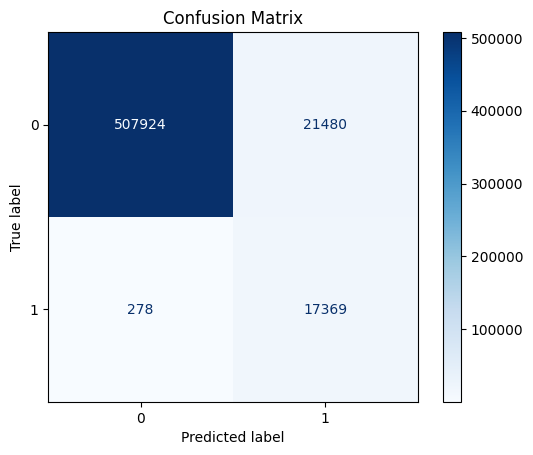

In [1]:
from joblib import load
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import os
import pickle


# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

# Tải Node2Vec model
# Tải mô hình đã huấn luyện
model = joblib.load(model_checkpoint)

train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
print("Train and test data loaded successfully from checkpoints.")

X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Ma trận nhầm lẫn
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


##6.2 ROC Curve và AUC Report

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Test Combined Features loaded successfully.


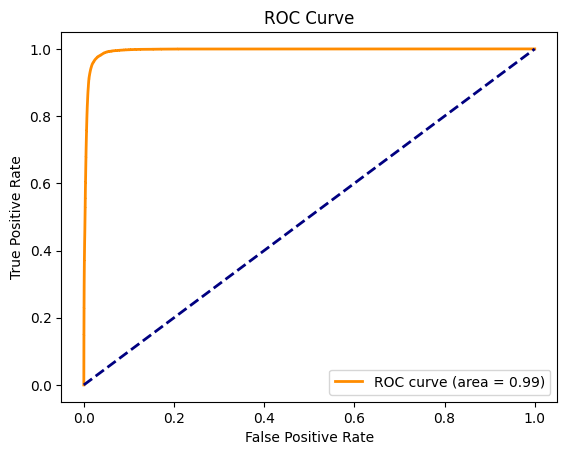

In [3]:
from joblib import load
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

# Tải Node2Vec model
# Tải mô hình đã huấn luyện
model = joblib.load(model_checkpoint)

train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
print("Train and test data loaded successfully from checkpoints.")

X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")

# Tính toán giá trị FPR, TPR
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Lấy xác suất của lớp dương
fpr, tpr, _ = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Vẽ ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()



##6.3 Feature Importance Report

In [ ]:
from joblib import load
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import os
import pickle

# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

# Tải Node2Vec model
# Tải mô hình đã huấn luyện
model = joblib.load(model_checkpoint)

train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
print("Train and test data loaded successfully from checkpoints.")

X_train = load_checkpoint(f"{project_path}train_combined_features.pkl", "Train Combined Features")
X_train = pd.DataFrame(X_train)
X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")
# Lấy độ quan trọng của đặc trưng
feature_importances = model.feature_importances_
# Lấy tên đặc trưng nếu là DataFrame hoặc tự tạo tên nếu là NumPy array
features = (
    X_train.columns if isinstance(X_train, pd.DataFrame)
    else [f"Feature {i}" for i in range(X_train.shape[1])]
)

# Sắp xếp độ quan trọng
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(sorted_idx)), np.array(features)[sorted_idx], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()
print(f"Feature Importance{np.array(features)[sorted_idx][:5]}")

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Train Combined Features loaded successfully.


##6.4 Precision-Recall Curve Report

In [ ]:
from joblib import load
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import pandas as pd
import numpy as np
import joblib
import os
import pickle

# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

# Tải Node2Vec model
# Tải mô hình đã huấn luyện
#model = joblib.load(model_checkpoint)

train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
print("Train and test data loaded successfully from checkpoints.")

X_train = load_checkpoint(f"{project_path}train_combined_features.pkl", "Train Combined Features")
X_train = pd.DataFrame(X_train)
X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")

precision, recall, _ = precision_recall_curve(test_labels, y_pred_prob)

# Vẽ Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, lw=2, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Train Combined Features loaded successfully.


##6.5 Learning Curve Report

Kiểm tra và Đảm bảo load dữ liệu từ phần 1
Train-Test Data loaded successfully.
Train and test data loaded successfully from checkpoints.
Train Combined Features loaded successfully.
Test Combined Features loaded successfully.


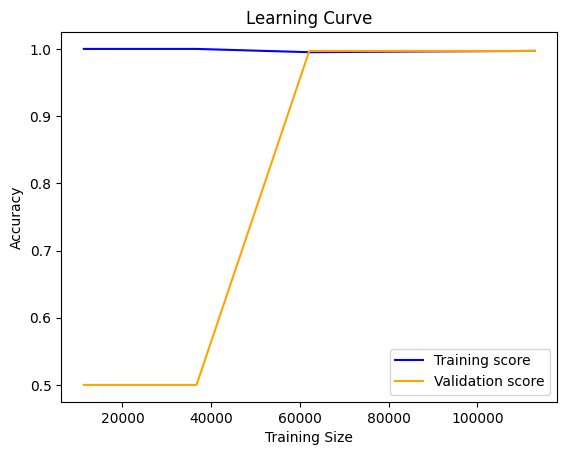

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
from joblib import load
import matplotlib.pyplot as plt

# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
test_combined_checkpoint_path = f"{project_path}test_combined_features.pkl"

# Hàm load check point
def load_checkpoint(path, description="Checkpoint"):
    if os.path.exists(path):
        with open(path, 'rb') as f:
            print(f"{description} loaded successfully.")
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"{description} not found at {path}.")

# Tải Node2Vec model
# Tải mô hình đã huấn luyện
model = joblib.load(model_checkpoint)

train_test_data_checkpoint_path = f"{project_path}train_test_data.pkl"
print("Kiểm tra và Đảm bảo load dữ liệu từ phần 1")
train_test_data = load_checkpoint(f"{project_path}train_test_data.pkl", "Train-Test Data")
train_labels, test_labels = train_test_data["train_labels"], train_test_data["test_labels"]
print("Train and test data loaded successfully from checkpoints.")

X_train = load_checkpoint(f"{project_path}train_combined_features.pkl", "Train Combined Features")
X_train = pd.DataFrame(X_train)
X_test = load_checkpoint(f"{project_path}test_combined_features.pkl", "Test Combined Features")

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, train_labels, cv=5, scoring="accuracy", n_jobs=-1
)

# Tính trung bình và độ lệch chuẩn
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Vẽ Learning Curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Validation score", color="orange")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

#PHẦN 7: GIẢ LẬP: RECOMMENDATION - DỰ ĐOÁN CÁC LIÊN KẾT TIỀM NĂNG

##Phần 7.1: Tạo danh sách các cạnh chưa có liên kết (potential links) - Tạo 1000 cạnh

In [ ]:
import networkx as nx
import random
import pandas as pd

# Đường dẫn tệp lưu potential_links
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
processed_graph_path = f"{project_path}processed_graph.graphml"
potential_links_path = f"{project_path}potential_links.csv"

# Tải đồ thị đã xử lý từ file processed_graph.graphml
G = nx.read_graphml(processed_graph_path)

# Số lượng potential links cần tạo
num_links = 1000

# Tạo danh sách các node
nodes = list(G.nodes())
existing_edges = set(G.edges())
potential_links = set()

# Tạo các cạnh tiềm năng
while len(potential_links) < num_links:
    u, v = random.sample(nodes, 2)  # Chọn 2 node ngẫu nhiên
    if (u, v) not in existing_edges and (v, u) not in existing_edges and (u, v) not in potential_links:
        potential_links.add((u, v))

# Chuyển đổi sang DataFrame và lưu thành file CSV
potential_links_df = pd.DataFrame(list(potential_links), columns=["node1", "node2"])
potential_links_df.to_csv(potential_links_path, index=False)

print(f"Đã tạo và lưu {num_links} potential links tại: {potential_links_path}")


Đã tạo và lưu 1000 potential links tại: /content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/potential_links.csv


##Phần 7.2: Dự đoán liên kết tiềm năng từ danh sách potential links

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm

# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"

# Đường dẫn checkpoint đặc trưng
nodes_features_checkpoint_path = f"{project_path}nodes_features.pkl"

# Đọc danh sách potential_links (cần tạo sẵn trước)
potential_links_path = f"{project_path}potential_links.csv"  # Danh sách cạnh tiềm năng
output_recommendation_path = f"{project_path}recommendation_links.csv"

# Hàm chuẩn bị đặc trưng cho các cạnh tiềm năng
def prepare_features(data, feature_dict, model):
    combined_features = []
    for u, v in tqdm(data, desc="Preparing features for potential links"):
        if u in model.wv and v in model.wv:
            # Vector nhúng của u và v
            embedding_u = model.wv[u]
            embedding_v = model.wv[v]

            # Đặc trưng thủ công
            handcrafted_features = feature_dict.get((u, v), np.zeros(7))  # Nếu không có đặc trưng, thay bằng 0

            # Kết hợp vector nhúng và đặc trưng thủ công
            combined_features.append(
                np.concatenate([embedding_u, embedding_v, handcrafted_features])
            )
        else:
            combined_features.append(None)  # Lưu None nếu không có vector nhúng
    return combined_features

try:
    print("Bắt đầu kiểm thử Recommendation...")

    # Tải mô hình đã huấn luyện
    clf = joblib.load(model_checkpoint)
    print("Random Forest model loaded successfully.")

    # Tải Node2Vec model
    with open(node2vec_full_model_checkpoint_path, 'rb') as f:
        node2vec_model = pickle.load(f)
    print("Node2Vec model loaded successfully.")

    # Tải đặc trưng từ checkpoints
    try:
        if os.path.exists(nodes_features_checkpoint_path):
            with open(nodes_features_checkpoint_path, 'rb') as f:
                features_data = pickle.load(f)
            nodes_features = features_data  # Cập nhật biến nodes_features
            print("Nodes features loaded successfully!")
        else:
            raise FileNotFoundError("File nodes_features.pkl không tồn tại!")
    except Exception as e:
        print(f"Lỗi khi tải nodes_features: {e}")

    # Tải danh sách potential links
    potential_links = pd.read_csv(potential_links_path).values.tolist()
    print(f"Loaded {len(potential_links)} potential links.")

    # Chuẩn bị đặc trưng cho potential links
    potential_features = prepare_features(potential_links, nodes_features, node2vec_model)

    # Loại bỏ các cạnh không hợp lệ (None features)
    valid_links = [link for link, features in zip(potential_links, potential_features) if features is not None]
    valid_features = [features for features in potential_features if features is not None]

    # Dự đoán xác suất
    predictions = clf.predict_proba(valid_features)[:, 1]  # Xác suất của lớp 1 (có cạnh)

    # Sắp xếp và chọn top 20 recommendation links
    top_indices = np.argsort(predictions)[-20:][::-1]  # Lấy 20 giá trị cao nhất
    top_links = [(valid_links[i], predictions[i]) for i in top_indices]

    recommendation_df = pd.DataFrame(top_links, columns=["link", "probability"])

    # Xuất kết quả ra file CSV
    #recommendation_df.to_csv(output_recommendation_path, index=False)
    #print(f"Đã hoàn thành kiểm thử Recommendation. Kết quả được lưu tại: {output_recommendation_path}")

    print(f"Danh sách top 20 liên kết được dự đoán dựa trên xác suất cao nhất")
    print(recommendation_df)

except Exception as e:
    print(f"Lỗi xảy ra khi kiểm thử Recommendation: {e}")


Bắt đầu kiểm thử Recommendation...
Random Forest model loaded successfully.
Node2Vec model loaded successfully.
Nodes features loaded successfully!
Loaded 1000 potential links.


Preparing features for potential links: 100%|██████████| 1000/1000 [00:00<00:00, 26236.37it/s]

Danh sách top 20 liên kết được dự đoán dựa trên xác suất cao nhất
            link  probability
0   [2230, 3102]          1.0
1    [975, 2556]          1.0
2   [1411, 1053]          1.0
3    [1736, 828]          1.0
4   [1307, 1130]          1.0
5     [84, 2056]          1.0
6    [1912, 873]          1.0
7   [3454, 1140]          1.0
8   [3453, 3073]          1.0
9   [1621, 2543]          1.0
10  [1529, 1432]          1.0
11    [526, 113]          1.0
12   [446, 3687]          1.0
13  [2275, 4019]          1.0
14  [2291, 3305]          1.0
15  [2006, 1322]          1.0
16   [552, 2790]          1.0
17  [2111, 1633]          1.0
18   [2039, 442]          1.0
19  [1033, 3462]          1.0


##Phần 7.3: Giải lập - Tìm 10 potential links (xác suất cao nhất) khi đưa 1 node vào

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import networkx as nx

# Hàm tạo đặc trưng cho các liên kết tiềm năng (potential links)
def generate_features_for_potential_links(data, feature_dict, model):
    combined_features = []
    for u, v in tqdm(data, desc="Preparing features for potential links"):
        if u in model.wv and v in model.wv:
            # Vector nhúng của u và v
            embedding_u = model.wv[u]
            embedding_v = model.wv[v]

            # Đặc trưng thủ công
            handcrafted_features = feature_dict.get((u, v), np.zeros(7))  # Nếu không có đặc trưng, thay bằng 0

            # Kết hợp vector nhúng và đặc trưng thủ công
            combined_features.append(
                np.concatenate([embedding_u, embedding_v, handcrafted_features])
            )
        else:
            combined_features.append(None)  # Lưu None nếu không có vector nhúng
    return combined_features

# Hàm gợi ý các liên kết tiềm năng cho một node
def recommend_links_for_node(input_node, graph, model, node2vec_model, nodes_features, top_k=10):
    # Lấy tất cả các node trong đồ thị
    all_nodes = list(graph.nodes())

    # Tạo danh sách các cặp node tiềm năng (u, v) với u là input_node và v là tất cả các node khác
    potential_links = [(input_node, v) for v in all_nodes if v != input_node and not graph.has_edge(input_node, v)]

    # Tạo đặc trưng cho các potential links
    X_potential_links = generate_features_for_potential_links(potential_links, nodes_features, node2vec_model)

    # Dự đoán xác suất cho các liên kết tiềm năng
    predicted_probs = model.predict_proba(X_potential_links)[:, 1]  # Lấy xác suất của lớp 1 (có liên kết)

    # Gợi ý top_k liên kết có xác suất cao nhất
    top_k_indices = np.argsort(predicted_probs)[-top_k:][::-1]
    top_k_recommendations = [potential_links[i] for i in top_k_indices]
    top_k_scores = [predicted_probs[i] for i in top_k_indices]

    return top_k_recommendations, top_k_scores

# Hàm chính để kiểm thử
def test_recommendation(input_node, graph, model, node2vec_model, nodes_features, top_k=10):
    try:
        # Gọi hàm gợi ý để nhận các liên kết tiềm năng
        recommendations, scores = recommend_links_for_node(input_node, graph, model, node2vec_model, nodes_features, top_k)

        print(f"Top {top_k} recommendations for node {input_node}:")
        for i, (link, score) in enumerate(zip(recommendations, scores)):
            print(f"{i+1}. Link: {link} - Score: {score:.4f}")

    except Exception as e:
        print(f"Error during recommendation: {e}")

# Đường dẫn
project_path = "/content/drive/MyDrive/Chương trình thạc sĩ/Mạng xã hội - Social Network/Đồ án môn học/"
processed_graph_path = f"{project_path}processed_graph.graphml"
model_checkpoint = f"{project_path}ML_RandomForest_model.pkl"
node2vec_full_model_checkpoint_path = f"{project_path}node2vec_full_model.pkl"
# Đường dẫn checkpoint đặc trưng
nodes_features_checkpoint_path = f"{project_path}nodes_features.pkl"

# Tải đồ thị đã xử lý từ file processed_graph.graphml
G = nx.read_graphml(processed_graph_path)
# Tải mô hình đã huấn luyện
clf = joblib.load(model_checkpoint)
print("Random Forest model loaded successfully.")
# Tải Node2Vec model
with open(node2vec_full_model_checkpoint_path, 'rb') as f:
    node2vec_model = pickle.load(f)
    print("Node2Vec model loaded successfully.")

# Tải đặc trưng từ checkpoints
try:
    if os.path.exists(nodes_features_checkpoint_path):
        with open(nodes_features_checkpoint_path, 'rb') as f:
            features_data = pickle.load(f)
        nodes_features = features_data  # Cập nhật biến nodes_features
        print("Nodes features loaded successfully!")
    else:
        raise FileNotFoundError("File nodes_features.pkl không tồn tại!")
except Exception as e:
    print(f"Lỗi khi tải nodes_features: {e}")

# Ví dụ về cách sử dụng hàm trên
input_node = "24"  # Chọn một node bất kỳ
top_k = 10  # Số lượng liên kết tiềm năng cần gợi ý

# Kiểm thử với model và dữ liệu đã được huấn luyện và load sẵn
test_recommendation(input_node, G, clf, node2vec_model, nodes_features, top_k)


Random Forest model loaded successfully.
Node2Vec model loaded successfully.
Nodes features loaded successfully!


Preparing features for potential links: 100%|██████████| 4022/4022 [00:00<00:00, 70969.37it/s]

Top 10 recommendations for node 24:
1. Link: ('24', '2069') - Score: 0.9995
2. Link: ('24', '2266') - Score: 0.9995
3. Link: ('24', '2034') - Score: 0.9995
4. Link: ('24', '629') - Score: 0.9995
5. Link: ('24', '650') - Score: 0.9995
6. Link: ('24', '2044') - Score: 0.9995
7. Link: ('24', '2058') - Score: 0.9995
8. Link: ('24', '1105') - Score: 0.9995
9. Link: ('24', '364') - Score: 0.9995
10. Link: ('24', '2312') - Score: 0.9995
